In [1]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, diffpair_cc, current_mirror_cc, spice_sim, cm_pmos
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import paretoset as pareto

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

# LDO with IHP-SG13G2 low voltage, full cascode (teleescopic OTA)

In [14]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                    # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp2 = 20e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,1.200000e+00
Vin,1.800000e+00
Vref,9.000000e-01
IL,5.000000e-03
CL,5.000000e-13
RL,2.400000e+02
Iq_max,1.000000e-04
Ib_pt,7.500000e-05
R1,4.000000e+03
R2,1.200000e+04


# Step-1: Pre-exploration

## Macromodels definition

In [15]:
Vota = 1.122

In [16]:
## LDO MACROMODEL

LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

## OTA CASCODE DIFFPAIR MACROMODEL

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')
    ],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

## Testbenches

### LDO

In [17]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*3.3)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

### OTA

In [18]:
gain_OTA = Test()
gain_OTA.tf = ("vout", "vpos")
gain_OTA.name = "gain_OTA"
gain_OTA.netlist = "ota_1stage"
gain_OTA.parametros = {
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("gdiff_2"): Symbol("gdiff_1"), 
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("V1"): 0,
    Symbol("V_b"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0,
    Symbol("Cl"): 1e-1}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "ota_1stage_rout"
rout_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "ota_1stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

## Primitives definition

### LDO primitives

In [19]:
pt = cs_pmos(
    lut_file="../../LUTs/IHP_LUT_lv_10w.npy",
    lut_w=10e-6,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): pt_df['cgd'].values,
    Symbol("Cin_pt"): pt_df['cgg'].values+pt_df["cgd"].values*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"].values/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table('../../LUTs/IHP_LUT_lv_10w.npy')

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file="../../LUTs/IHP_LUT_lv_10w.npy",
    lut_w=10e-6,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        +pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        *pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.34959328 -0.34123741 -0.33644854 -0.33398078 -0.33278151]
length
vgs
0


In [20]:
pt.parameters[Symbol("dropout")]

array([0.32699654, 0.33976694, 0.34561542, 0.34779659, 0.34842231])

### OTA primitives

In [21]:
sweep_size_dp = 5
vin_dp = OTA_macro.electrical_parameters["Vref"]
vout_dp = OTA_macro.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_dp, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    "../../LUTs/IHP_LUT_lv_10w.npy",
    10e-6)

diffpair_primitive_df =  diffpair_primitive.build()

diffpair_primitive_mask = (diffpair_primitive_df["width_m1"]>1e-6) & (diffpair_primitive_df["width_m2"]>2e-5) & (diffpair_primitive_df["width_m1"]<6e-6) & (diffpair_primitive_df["width_m2"]<3e-4)

diffpair_primitive_df = diffpair_primitive_df[diffpair_primitive_mask]

diffpair_primitive.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df["Ro"].values, 
                                 Symbol("gdiff_1"): diffpair_primitive_df["gm"].values,
                                 Symbol("vbias"): diffpair_primitive_df["vbias"].values,
                                 Symbol("vs_diff"): diffpair_primitive_df["vs"].values}

diffpair_primitive.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

vout_cm = 1.12 - Vin
sweep_size_cm = 5

vcp_cm = np.linspace(vout_cm+0.1, -0.1, sweep_size_cm)

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive = current_mirror_cc(
    vcp_cm, 
    vout_cm, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    "../../LUTs/IHP_LUT_lv_10w.npy",
    10e-6)

activeload_primitive_df = activeload_primmitive.build()

activeload_primitive_mask = (activeload_primitive_df["width_m1"]>1e-6) & (activeload_primitive_df["width_m2"]>1e-5) & (activeload_primitive_df["width_m1"]<3e-4) & (activeload_primitive_df["width_m2"]<3e-4)
activeload_primitive_df = activeload_primitive_df[activeload_primitive_mask]

activeload_primmitive.parameters = {Symbol("Raload_1"): activeload_primitive_df["Ro"].values,
                                    Symbol("gaload_1"): activeload_primitive_df["gm"].values,
                                    Symbol("vbias_cm"): activeload_primitive_df["vbias"].values}
activeload_primmitive.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}
                                 

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}

for vds_cs in vs_dp:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file="../../LUTs/ihp_lut_lv_10w.npy",
        lut_w=10e-6,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp2,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

mask = currentsource.outputs[Symbol('W_cs')]>1e-6

currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()[mask]
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()[mask]
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()[mask]
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()[mask]
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()[mask]
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()[mask]
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]


vds
vgs
1
M1 jd:  [[1.11754128e+02 5.06140332e+01 1.36957246e+01 8.93613718e-01
  4.44591923e-03 1.12291503e+02 5.09760756e+01 1.38801966e+01
  9.26460627e-01 4.73485801e-03 1.12808349e+02 5.13254778e+01
  1.40597748e+01 9.59717508e-01 4.99806627e-03 1.13306754e+02
  5.16636098e+01 1.42349637e+01 9.93121381e-01 5.25981046e-03
  1.13788376e+02 5.19929781e+01 1.44057804e+01 1.02547842e+00
  5.52362737e-03]
 [6.88142068e+01 3.30168624e+01 1.03325732e+01 1.04649822e+00
  7.36511737e-03 6.90723115e+01 3.31990725e+01 1.04345940e+01
  1.07253342e+00 7.74246522e-03 6.93203556e+01 3.33746523e+01
  1.05335057e+01 1.09866091e+00 8.07141088e-03 6.95593973e+01
  3.35442647e+01 1.06296405e+01 1.12469025e+00 8.40003718e-03
  6.97902869e+01 3.37093179e+01 1.07230421e+01 1.14976572e+00
  8.73251151e-03]
 [3.83563259e+01 1.89901806e+01 6.41425358e+00 8.20202898e-01
  7.89852041e-03 3.84702868e+01 1.90729657e+01 6.46306551e+00
  8.35042021e-01 8.23046461e-03 3.85797999e+01 1.91526610e+01
  6.51024731e+00

In [22]:
len(currentsource.outputs[Symbol('W_cs')])

62

In [23]:
vout_2stage_wc = 1.45

In [24]:
diffpair_primitive_wc = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_2stage_wc, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    "../../LUTs/IHP_LUT_lv_10w.npy",
    10e-6)

diffpair_primitive_df_wc =  diffpair_primitive_wc.build()

diffpair_primitive_wc.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df_wc["Ro"].values[diffpair_primitive_mask], 
                                 Symbol("gdiff_1"): diffpair_primitive_df_wc["gm"].values[diffpair_primitive_mask],
                                 Symbol("vbias"): diffpair_primitive_df_wc["vbias"].values[diffpair_primitive_mask],
                                 Symbol("vs_diff"): diffpair_primitive_df_wc["vs"].values[diffpair_primitive_mask]}
diffpair_primitive_wc.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive_wc = current_mirror_cc(
    vcp_cm, 
    vout_2stage_wc-1.8, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    "../../LUTs/IHP_LUT_lv_10w.npy",
    10e-6)

activeload_primitive_df_wc = activeload_primmitive_wc.build()

activeload_primmitive_wc.parameters = {Symbol("Raload_1"): activeload_primitive_df_wc["Ro"].values[activeload_primitive_mask],
                                    Symbol("gaload_1"): activeload_primitive_df_wc["gm"].values[activeload_primitive_mask],
                                    Symbol("vbias_cm"): activeload_primitive_df_wc["vbias"].values[activeload_primitive_mask]}

activeload_primmitive_wc.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}

vds
vgs
1
M1 jd:  [[1.11754128e+02 5.06140332e+01 1.36957246e+01 8.93613718e-01
  4.44591923e-03 1.12291503e+02 5.09760756e+01 1.38801966e+01
  9.26460627e-01 4.73485801e-03 1.12808349e+02 5.13254778e+01
  1.40597748e+01 9.59717508e-01 4.99806627e-03 1.13306754e+02
  5.16636098e+01 1.42349637e+01 9.93121381e-01 5.25981046e-03
  1.13788376e+02 5.19929781e+01 1.44057804e+01 1.02547842e+00
  5.52362737e-03]
 [6.88142068e+01 3.30168624e+01 1.03325732e+01 1.04649822e+00
  7.36511737e-03 6.90723115e+01 3.31990725e+01 1.04345940e+01
  1.07253342e+00 7.74246522e-03 6.93203556e+01 3.33746523e+01
  1.05335057e+01 1.09866091e+00 8.07141088e-03 6.95593973e+01
  3.35442647e+01 1.06296405e+01 1.12469025e+00 8.40003718e-03
  6.97902869e+01 3.37093179e+01 1.07230421e+01 1.14976572e+00
  8.73251151e-03]
 [3.83563259e+01 1.89901806e+01 6.41425358e+00 8.20202898e-01
  7.89852041e-03 3.84702868e+01 1.90729657e+01 6.46306551e+00
  8.35042021e-01 8.23046461e-03 3.85797999e+01 1.91526610e+01
  6.51024731e+00

# OTA explore

In [5]:
ldo = pd.read_csv("data/IHP_lv_ldo_explore2_topo3.csv")

In [6]:
ldo

,Unnamed: 0,Ra,gma,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,Cin_pt,dropout,Vota,...,psrr_wc,gain_ol,gain_ol_wc,Vota_wc,cin_pt_wc,gmid,phase_margin_LDO_wc,loadreg,bw,gain_ota
0,1,2.007544e+07,0.000071,0.031061,1502.195819,1.558011e-12,8.692283e-15,1.963585e-12,0.326781,1.122,...,-59.904216,79.108305,55.642097,1.45,9.160555e-13,6.120314,90.407767,1.046777,53.024589,63.058913
1,13,2.007525e+07,0.000071,0.031061,1502.195819,1.558011e-12,8.692283e-15,1.963585e-12,0.326781,1.122,...,-59.904266,79.108331,55.642147,1.45,9.160555e-13,6.120314,90.407767,1.046772,53.025086,63.058939
2,29,2.021842e+07,0.000071,0.031061,1502.195819,1.558011e-12,8.692283e-15,1.963585e-12,0.326781,1.122,...,-62.400899,79.182722,58.143557,1.45,9.160555e-13,6.120314,90.384317,0.918934,52.649602,63.133330
3,41,2.021823e+07,0.000071,0.031061,1502.195819,1.558011e-12,8.692283e-15,1.963585e-12,0.326781,1.122,...,-62.400923,79.182745,58.143582,1.45,9.160555e-13,6.120314,90.384317,0.918932,52.650108,63.133352
4,71,2.007701e+07,0.000071,0.031061,1502.195819,1.558011e-12,8.692283e-15,1.963585e-12,0.326781,1.122,...,-61.968615,79.121766,57.710541,1.45,9.160555e-13,6.120314,90.387930,0.941667,53.020447,63.072374
5,83,2.007682e+07,0.000071,0.031061,1502.195819,1.558011e-12,8.692283e-15,1.963585e-12,0.326781,1.122,...,-61.968643,79.121789,57.710569,1.45,9.160555e-13,6.120314,90.387930,0.941664,53.020948,63.072397


In [25]:
len(diffpair_primitive_df)*len(activeload_primitive_df)*len(currentsource.parameters[Symbol("gcs")])

859320

## Caso 2

In [26]:
OTA_macro.ext_mask = None

OTA_macro.primitives = [diffpair_primitive_wc, activeload_primmitive_wc, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, ota_df_wc_mask = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OTA_macro
Netlist:  ota_1stage
Running MNA... 
MNA of gain_OTA took: 0.051360368728637695
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
MNA of rout_OTA took: 0.026571035385131836
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
MNA of gm_OTA took: 0.02498483657836914
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_

: 

## Caso 1

In [1]:
OTA_macro.ext_mask = ota_df_wc_mask

OTA_macro.primitives = [diffpair_primitive, activeload_primmitive, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

NameError: name 'ota_df_wc_mask' is not defined

## Filtering

In [170]:
ota_df.sort_values(by="gain")

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area,gain,gain_wc,bw
15222,3.774693e+07,0.000018,1.17200,0.45,1.129026e+07,0.000009,-0.445,0.000035,1.242584e+06,0.45,...,0.000006,0.000006,0.000021,4.000000e-07,0.000002,6.400000e-06,0.000172,43.668576,53.349558,3762.829186
15220,3.774693e+07,0.000018,1.17200,0.45,1.129026e+07,0.000009,-0.445,0.000037,9.955386e+05,0.45,...,0.000006,0.000006,0.000021,4.000000e-07,0.000001,3.200000e-06,0.000168,43.668801,53.349568,3762.858263
15221,3.774693e+07,0.000018,1.17200,0.45,1.129026e+07,0.000009,-0.445,0.000081,6.242964e+05,0.45,...,0.000006,0.000006,0.000021,4.000000e-07,0.000021,6.400000e-06,0.000190,43.669462,53.349597,3762.943351
15219,3.774693e+07,0.000018,1.17200,0.45,1.129026e+07,0.000009,-0.445,0.000086,4.811393e+05,0.45,...,0.000006,0.000006,0.000021,4.000000e-07,0.000013,3.200000e-06,0.000179,43.669974,53.349620,3763.009290
15218,3.774693e+07,0.000018,1.17200,0.45,1.129026e+07,0.000009,-0.445,0.000094,3.641352e+05,0.45,...,0.000006,0.000006,0.000021,4.000000e-07,0.000009,1.600000e-06,0.000174,43.670669,53.349651,3763.098905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61563,1.081966e+08,0.000018,1.12625,0.45,2.694046e+08,0.000012,-0.535,0.000081,6.242964e+05,0.45,...,0.000002,0.000003,0.000200,3.200000e-06,0.000021,6.400000e-06,0.000318,62.703242,66.695680,424.073925
61561,1.081966e+08,0.000018,1.12625,0.45,2.694046e+08,0.000012,-0.535,0.000086,4.811393e+05,0.45,...,0.000002,0.000003,0.000200,3.200000e-06,0.000013,3.200000e-06,0.000307,62.703258,66.695682,424.075877
61560,1.081966e+08,0.000018,1.12625,0.45,2.694046e+08,0.000012,-0.535,0.000094,3.641352e+05,0.45,...,0.000002,0.000003,0.000200,3.200000e-06,0.000009,1.600000e-06,0.000301,62.703279,66.695684,424.078530
61559,1.081966e+08,0.000018,1.12625,0.45,2.694046e+08,0.000012,-0.535,0.000105,2.682617e+05,0.45,...,0.000002,0.000003,0.000200,3.200000e-06,0.000007,8.000000e-07,0.000299,62.703310,66.695687,424.082264


In [169]:
Cin_pt = 4.86e-12
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["bw"] = 1/(2*np.pi*ota_df["rout_OTA"]*Cin_pt)

mask = ota_df["gain"]>10
ota_df = ota_df[mask]

ota_df_new = ota_df[ota_df["gain"]>63]
ota_df_new.sort_values(by="gain")

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area,gain,gain_wc,bw


In [17]:
ota_df_wc_new = ota_df_wc[mask][ota_df["gain"]>63]
ota_df_wc_new

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,L_diff_m1,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area


/tmp/ipykernel_16407/2579574295.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc = 'upper right')
/tmp/ipykernel_16407/2579574295.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')
/tmp/ipykernel_16407/2579574295.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc = 'upper right')


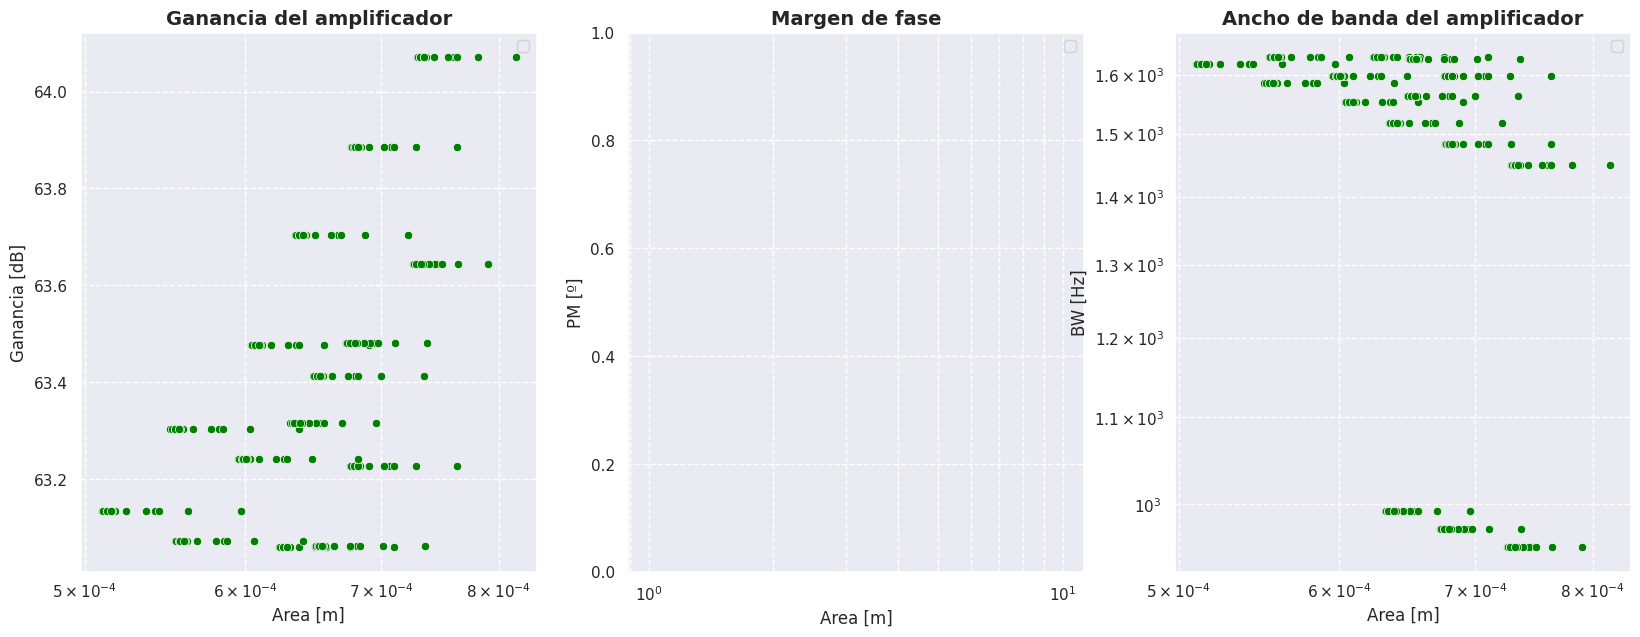

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
#sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare')
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
#sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
#sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
#sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('fullcc_ota_explore_raw.pdf')

/tmp/ipykernel_16407/3568088707.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper right')


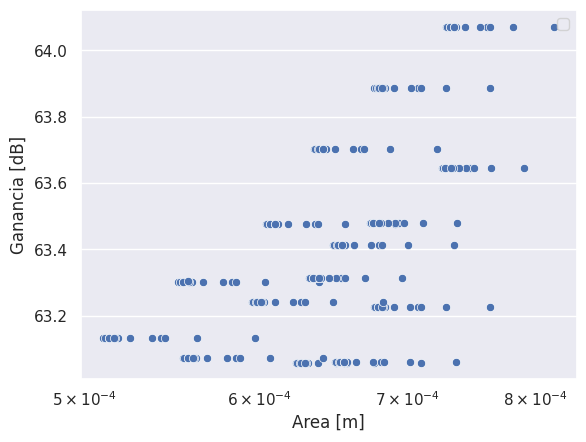

In [26]:
sns.scatterplot(data=ota_df_new, x='area', y='gain')
plt.xlabel(r"Area [m]")
plt.ylabel(r"Ganancia [dB]")
plt.locator_params(axis='x', nbins=10) 
plt.legend(loc = 'upper right')
plt.xscale("log")

plt.savefig('gain_topo3.pdf')

# LDO explore

## Case 2

In [9]:
OTA_primitive_wc = Primitive(
    parameters={
        Symbol("Ra"): ota_df_wc_new["rout_OTA"],
        Symbol("gma"): ota_df_wc_new["gm_OTA"],
    }
)

OTA_primitive_wc.outputs = {
    Symbol("W_diff_m1"): ota_df_wc_new[Symbol("W_diff_m1")].values,
    Symbol("L_diff_m1"): ota_df_wc_new[Symbol("L_diff_m1")].values,
    Symbol("W_diff_m2"): ota_df_wc_new[Symbol("W_diff_m2")].values,
    Symbol("L_diff_m2"): ota_df_wc_new[Symbol("L_diff_m2")].values,

    Symbol("W_aload_m1"): ota_df_wc_new[Symbol("W_aload_m1")].values,
    Symbol("L_aload_m1"): ota_df_wc_new[Symbol("L_aload_m1")].values,
    Symbol("W_aload_m2"): ota_df_wc_new[Symbol("W_aload_m2")].values,
    Symbol("L_aload_m2"): ota_df_wc_new[Symbol("L_aload_m2")].values,

    Symbol("W_cs"): ota_df_wc_new[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_wc_new[Symbol("L_cs")].values,
}

NameError: name 'ota_df_wc_new' is not defined

In [ ]:
pt_2_wc = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0019411907396011]),
        Symbol('Ro_pt'): np.asarray([109936.0448858981]),
        Symbol("Cgg_pt"): np.asarray([7.507718738430091e-13]),
        Symbol("Cgd_pt"): np.asarray([7.745003513700936e-16]),
        Symbol("Cin_pt"): np.asarray([9.160555404293312e-13]),
        Symbol("dropout"): np.asarray([0.077272159267986]),
        Symbol('Vota'): np.asarray([1.45])
    }
)

pt_2_wc.outputs = {
    Symbol("W_pt"): np.asarray([0.0005470250841739]),
    Symbol("L_pt"): np.asarray([4e-7])
}

In [ ]:
Cc_primitive_LDO_2 = Primitive(
    parameters={
        Symbol("Cc"): np.asarray([3.1622776601683798e-12]),
        Symbol("Rc"): np.asarray([1000.0])
    }
)

Cc_primitive_LDO_2.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, 1)
}

In [ ]:
LDO_macro.ext_mask = None

LDO_macro.primitives = [OTA_primitive_wc, pt_2_wc, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_df_wc_mask = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5


[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <function _lambdifygenerated at 0x7f54b8abe0e0>
#### creating the primods_list ####
primmods_outputs_aux:  {W_diff_m1: array([4.89709438e-06, 4.89709438e-06, 4.89709438e-06, 4.89709438e-06,
       4.89709438e-06, 4.89709438e-06, 4.89709438e-06, 4.89709438e-06,
       4.89709438e-06, 4.89709438e-06, 4.89709438e-06, 4.89709438e-06,
       4.89709438e-06, 4.89709438e-

## Case 1

In [ ]:
OTA_primitive = Primitive(
    parameters={
        Symbol("Ra"): ota_df_new["rout_OTA"],
        Symbol("gma"): ota_df_new["gm_OTA"],
    }
)

OTA_primitive.outputs = {
    Symbol("W_diff_m1"): ota_df_new[Symbol("W_diff_m1")].values,
    Symbol("L_diff_m1"): ota_df_new[Symbol("L_diff_m1")].values,
    Symbol("W_diff_m2"): ota_df_new[Symbol("W_diff_m2")].values,
    Symbol("L_diff_m2"): ota_df_new[Symbol("L_diff_m2")].values,

    Symbol("W_aload_m1"): ota_df_new[Symbol("W_aload_m1")].values,
    Symbol("L_aload_m1"): ota_df_new[Symbol("L_aload_m1")].values,
    Symbol("W_aload_m2"): ota_df_new[Symbol("W_aload_m2")].values,
    Symbol("L_aload_m2"): ota_df_new[Symbol("L_aload_m2")].values,

    Symbol("W_cs"): ota_df_new[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_new[Symbol("L_cs")].values,
}

In [ ]:
pt_2 = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0310605956289642]),
        Symbol('Ro_pt'): np.asarray([1502.1958194630895]),
        Symbol("Cgg_pt"): np.asarray([1.5580110817282832e-12]),
        Symbol("Cgd_pt"): np.asarray([8.692283358742219e-15]),
        Symbol("Cin_pt"): np.asarray([1.9635851732796777e-12]),
        Symbol("dropout"): np.asarray([0.3267805975534815]),
        Symbol('Vota'): np.asarray([1.122])
    }
)

pt_2.outputs = {
    Symbol("W_pt"): np.asarray([0.0005470250841739]),
    Symbol("L_pt"): np.asarray([4e-7])
}



In [ ]:
LDO_macro.ext_mask = ldo_df_wc_mask

LDO_macro.primitives = [OTA_primitive, pt_2, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <function _lambdifygenerated at 0x7f54be8b8a60>
#### creating the primods_list ####
primmods_outputs_aux:  {W_diff_m1: array([4.89709438e-06, 4.89709438e-06, 4.89709438e-06, 4.89709438e

## Filtering

In [10]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])

ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc[Symbol("Vota")]
ldo_df["cin_pt_wc"] = ldo_df_wc[Symbol("Cin_pt")]

ldo_df['gmid'] = ldo_df[Symbol('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[Symbol("Ra")]*(ldo_df[Symbol("Cin_pt")]+ldo_df[Symbol("gm_pt")]*ldo_df[Symbol("Ro_pt")]*ldo_df[Symbol("Cc")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[Symbol("Ra")]*ldo_df[Symbol("gma")])

#ldo_df = ldo_df[(ldo_df["gain_ota"]>20) & (ldo_df[Symbol("W_pt")]<0.6e-3) & (ldo_df[Symbol("dropout")]<0.4)]

ldo_df_new = ldo_df[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df[Symbol("W_pt")]<0.9e-3))]
#ldo_df_new = ldo_df
ldo_df_new.sort_values(by="area")

NameError: name 'ldo_df' is not defined

NameError: name 'ldo_df' is not defined

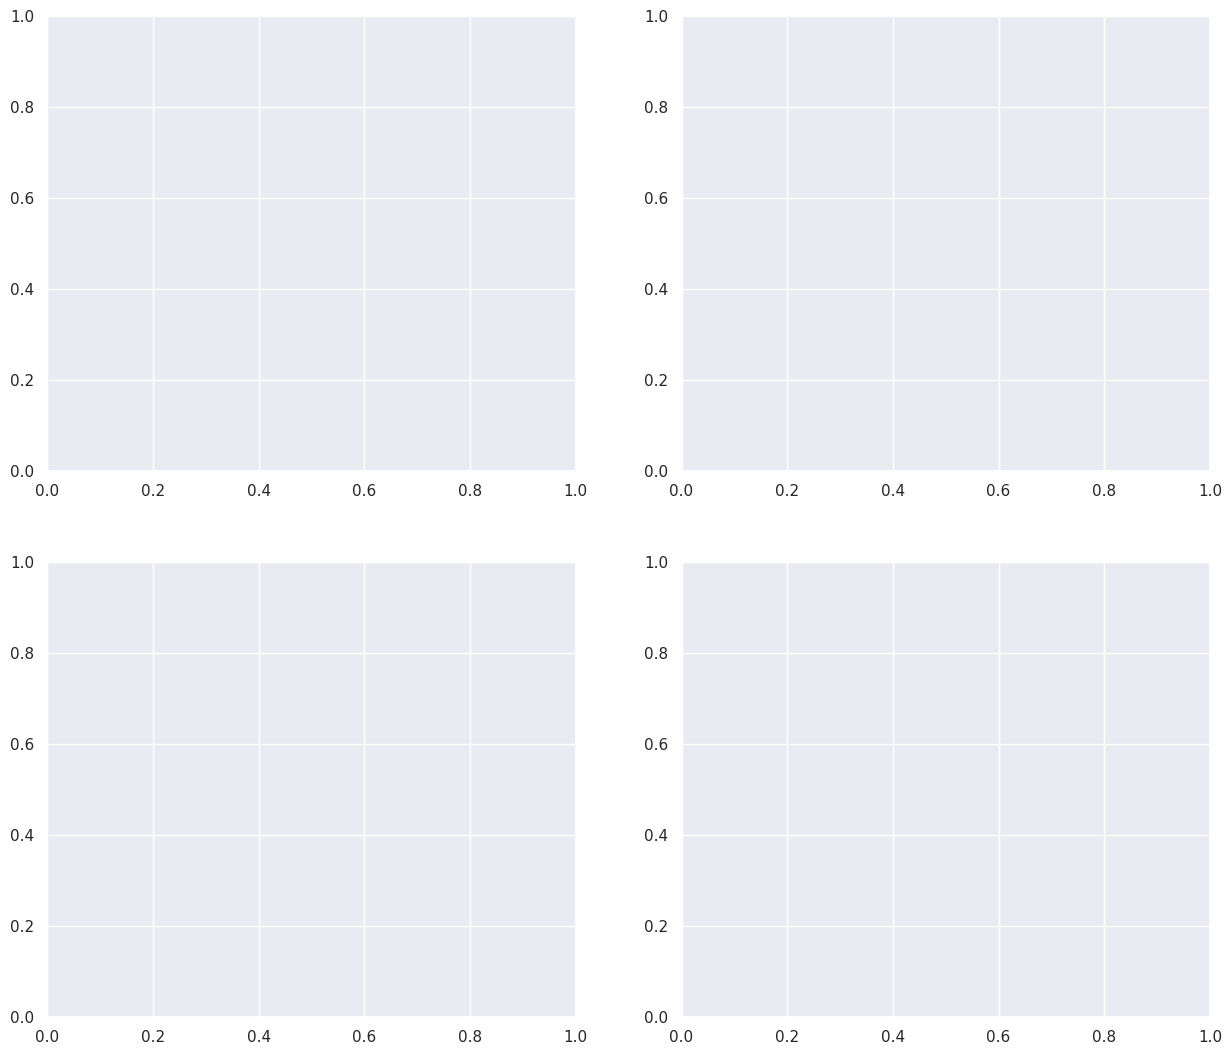

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
#sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
#sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df, x='area', y=Symbol('dropout'), palette='flare', hue='gmid', rasterized=True, size=Symbol('L_pt'))
#sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=Symbol('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
#sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "upper left")
sns.move_legend(axs[0,1], "upper left")
sns.move_legend(axs[1,0], "upper left")
sns.move_legend(axs[1,1], "upper left")

plt.savefig('ldo_explore_raw.pdf')

In [38]:
pareto_dict = {"area": ldo_df_new["area"], "phase_margin_LDO_wc": ldo_df_new["phase_margin_LDO_wc"]}
pareto_df = pd.DataFrame.from_dict(pareto_dict)
mask = pareto.paretoset(pareto_df, sense=["min", "max"])

ldo_df = ldo_df_new
ldo_df_new = ldo_df_new[mask]

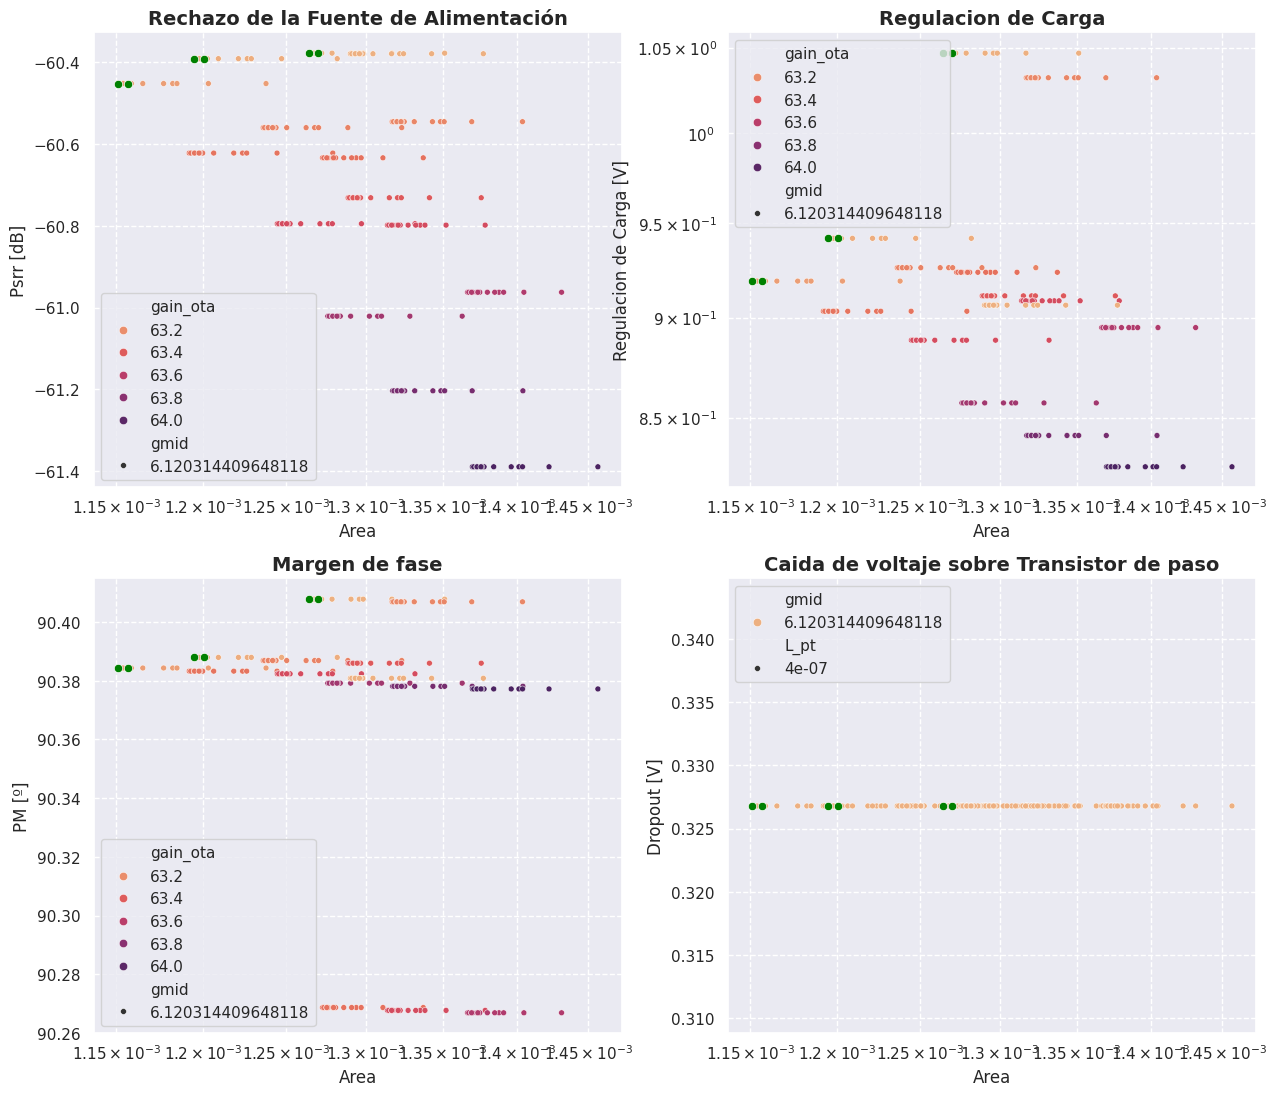

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df, x='area', y=Symbol('dropout'), palette='flare', hue='gmid', rasterized=True, size=Symbol('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=Symbol('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "lower left")
sns.move_legend(axs[0,1], "upper left")
sns.move_legend(axs[1,0], "lower left")
sns.move_legend(axs[1,1], "upper left")

plt.savefig('ldo_explore_raw.pdf')

In [41]:
ldo_df_new.to_csv("data/IHP_lv_ldo_explore2_topo3.csv")